# 🔬️ Laboratorio Modelos Ocultos de Markov
(HMM)

En este cuaderno se va a realizar un ejemplo de HMM aplicado a *Un casino que usa dados trucados*.

Este ejemplo, fué extraido y adapaptado de la colección de ejemplos de la [librería HMMLearn Dishonest Casino.🔗️](https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_casino.html)

In [ ]:
"""
Dishonest Casino Example
------------------------

We'll use the ubiquitous dishonest casino example to demonstrate
how to train a Hidden Markov Model (HMM) on somewhat realistic
test data (e.g. http://www.mcb111.org/w06/durbin_book.pdf
Chapter 3).

In this example, we suspect that a casino is trading out a fair
die (singular or dice) for a loaded die. We want to figure out
1) when the loaded die was used (i.e. the most likely path) 2) how
often the loaded die is used (i.e. the transition probabilities) and
3) the probabilities for each outcome of a roll for the loaded die
(i.e. the emission probabilities).
"""

In [3]:
!pip install numpy pandas scikit-learn plotly matplotlib hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:01


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

## 🔢️ Definición del modelo

Vamos a simular que el casino intercambia los dados con cierta probabilidad.

Esta probabilidad depende del estado actual.

In [17]:
# two components, a fair die and a loaded die

gen_model = hmm.CategoricalHMM(n_components=2, random_state=99)

# start with the fair die

gen_model.startprob_ = np.array([1.0, 0.0])

# transition matrix

gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])
# emission matrix

gen_model.emissionprob_ = \
    np.array([
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10], # loaded dice
        [1 / 6 , 1 / 6 , 1 / 6 , 1 / 6 , 1 / 6 , 1 / 6 ]  # fair dice
    ])

## 🧪️ Simulación

Lanzar los dados y guardar los resultados.

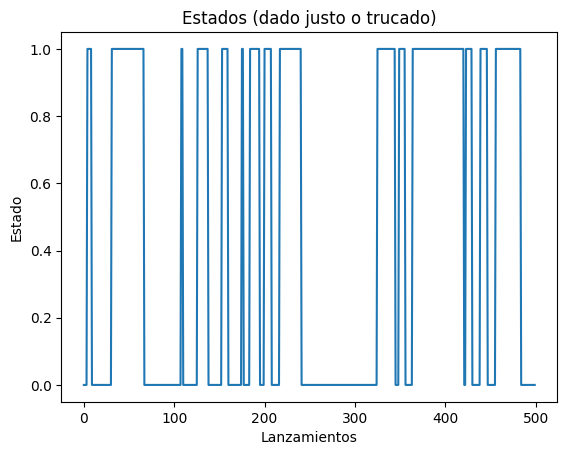

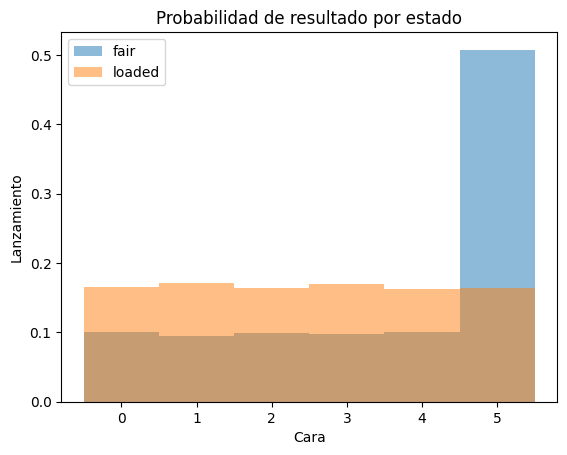

In [26]:
# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('Estados (dado justo o trucado)')
ax.set_xlabel('Lanzamientos')
ax.set_ylabel('Estado')

# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Probabilidad de resultado por estado')
ax.set_xlabel('Cara')
ax.set_ylabel('Lanzamiento')
ax.legend()

In [19]:
# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

## 🤖️ Entrenar y obtener el mejor modelo

Generar varios Modelo ocultos de Markov **categóricos**. Variando:
- Semilla
- Matriz de transición inicial

Estos modelos son clasificados por **Log Score**.

In [32]:
# check optimal score
gen_score = gen_model.score(X_validate)

best_score = best_model = None
n_fits = 50
np.random.seed(13)

for idx in range(n_fits):

    model = hmm.CategoricalHMM (
        n_components=2,
        random_state=idx,
        init_params='se'
    )
    
    # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    
    model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                                np.random.dirichlet([0.1, 0.9])])
    model.fit(X_train)
    score = model.score(X_validate)
    print(f'Model #{idx}\tScore: {score}')
    
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {gen_score}\nBest score:      {best_score}')

Model #0	Score: -24608.91032234689
Model #1	Score: -24613.64781458097
Model #2	Score: -24631.470637418486
Model #3	Score: -24616.062795793707
Model #4	Score: -24613.653672541466
Model #5	Score: -24543.68142828102
Model #6	Score: -24614.40130568069
Model #7	Score: -24468.45692453285
Model #8	Score: -24501.337467969468
Model #9	Score: -24506.648491525157
Model #10	Score: -24613.636714565757
Model #11	Score: -24624.291821614897
Model #12	Score: -24483.37380437593
Model #13	Score: -24614.64889588313
Model #14	Score: -24520.390819110027
Model #15	Score: -24468.66826021301
Model #16	Score: -24482.84675772344
Model #17	Score: -24492.576568802917
Model #18	Score: -24548.256588535354
Model #19	Score: -24625.136495137114
Model #20	Score: -24623.29343405078
Model #21	Score: -24613.518568753876
Model #22	Score: -24614.696918673904
Model #23	Score: -24609.10883254599
Model #24	Score: -24477.35374995011
Model #25	Score: -24585.372547110135
Model #26	Score: -24473.486241500475
Model #27	Score: -24614

## 📈️ Algoritmo de Viterbi

Basado en los resultados de los dados, nos permite predecir la secuencia de estados que con más probabilidad hubiese producido este resultado.

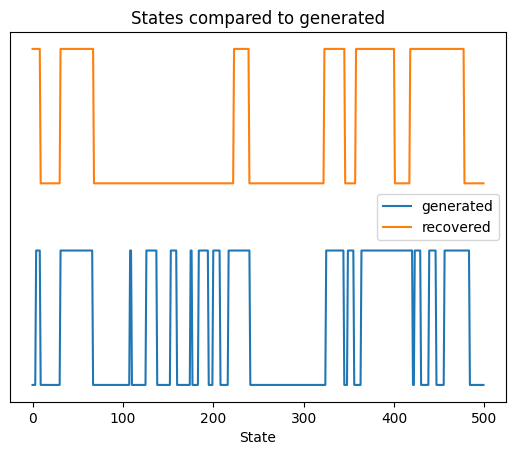

In [34]:
# Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()

In [35]:
# Let's check our learned transition probabilities and see if they match.

print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

# Finally, let's see if we can tell how the die is loaded.

print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

# In this case, we were able to get very good estimates of the transition and
# emission matrices, but decoding the states was imperfect. That's because
# the decoding algorithm is greedy and picks the most likely series of states
# which isn't necessarily what happens in real life. Even so, our model could
# tell us when to watch for the loaded die and we'd have a better chance at
# catching them red-handed.

Transmission Matrix Generated:
[[0.95 0.05]
 [0.1  0.9 ]]

Transmission Matrix Recovered:
[[0.96  0.04 ]
 [0.108 0.892]]


Emission Matrix Generated:
[[0.1   0.1   0.1   0.1   0.1   0.5  ]
 [0.167 0.167 0.167 0.167 0.167 0.167]]

Emission Matrix Recovered:
[[0.105 0.096 0.104 0.101 0.102 0.491]
 [0.168 0.172 0.17  0.185 0.166 0.138]]




## 📊️ Conclusión